In [1]:
# https://www.tensorflow.org/tutorials/structured_data/time_series
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
volume_file_name = 'Data/volume_data.pkl'
one_way_volume_df = pd.read_pickle(volume_file_name)
pd.set_option('display.max_columns', None)
one_way_volume_df

,station_id,dir_of_travel,datetime,lane_x,lane_1,lane_2,lane_3,lane_4,total
0,8,1,2012-07-02 00:00:00,0,0,0,0,0,0
1,8,1,2012-07-02 01:00:00,0,0,0,0,0,0
2,8,1,2012-07-02 02:00:00,0,0,0,0,0,0
3,8,1,2012-07-02 03:00:00,2,0,0,0,0,2
4,8,1,2012-07-02 04:00:00,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
25576843,6224,7,2021-02-27 19:00:00,0,235,7,0,0,242
25576844,6224,7,2021-02-27 20:00:00,0,224,6,0,0,230
25576845,6224,7,2021-02-27 21:00:00,0,165,3,0,0,168
25576846,6224,7,2021-02-27 22:00:00,0,130,1,0,0,131


In [4]:
one_way_volume_df.drop(['lane_x', 'lane_1', 'lane_2', 'lane_3', 'lane_4'], axis=1, inplace=True)
one_way_volume_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25576848 entries, 0 to 25576847
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   station_id     category      
 1   dir_of_travel  category      
 2   datetime       datetime64[ns]
 3   total          int16         
dtypes: category(2), datetime64[ns](1), int16(1)
memory usage: 292.7 MB


In [5]:
two_way_volume_df = one_way_volume_df.groupby(['station_id', 'datetime'], as_index=False, sort=False, observed=True).sum()
two_way_volume_df

,station_id,datetime,total
0,8,2012-07-02 00:00:00,4
1,8,2012-07-02 01:00:00,0
2,8,2012-07-02 02:00:00,0
3,8,2012-07-02 03:00:00,6
4,8,2012-07-02 04:00:00,0
...,...,...,...
12791851,6224,2021-02-27 19:00:00,505
12791852,6224,2021-02-27 20:00:00,480
12791853,6224,2021-02-27 21:00:00,358
12791854,6224,2021-02-27 22:00:00,231


In [6]:
current_stations_file = 'Data/Current_CC_StationList.xlsx'
current_df = pd.read_excel(current_stations_file)
current_stations = current_df['Continuous Number'].values
current_df

,Continuous Number,Sequence Number,Collection Type,Route,Pos Dir Dir,Pos Lanes,Neg Lanes,Urban/Rural,Functional Class,County Name,Location Text
0,26,5707,WIM,I-35,North,2,2,Rural,Interstate,Steele,"3.5 MI N OF TH30, N OF ELLENDALE"
1,27,9830,WIM,TH 60,East,2,2,Rural,Principal Arterial - Other,Watonwan,"0.7 MI W OF W JCT OF TH4, SW OF ST JAMES"
2,28,22993,"ATR Volume, Speed, Class",MSAS 114,East,1,1,Urban,Minor Arterial,Stearns,W OF 20TH AVE N IN ST CLOUD
3,29,69377,WIM,TH 53,North,2,2,Rural,Principal Arterial - Other,Saint Louis,"3 MI S OF CSAH59 (MELRUDE RD), S OF EVELETH"
4,30,6757,WIM,TH 61,North,2,2,Rural,Principal Arterial - Other,Lake,"SW OF CSAH25, SW OF TWO HARBORS"
...,...,...,...,...,...,...,...,...,...,...,...
99,4820,4820,"ATR Volume, Speed, Length",I-90,East,2,2,Rural,Interstate,Rock,"W OF CSAH 4, W OF BEAVER CREEK"
100,4910,4910,"ATR Volume, Speed, Length",TH 53,North,2,2,Rural,Principal Arterial - Other,Saint Louis,"N OF CSAH8 (DULUTH SAINT VINCENT RD), NW OF HE..."
101,5984,5984,"ATR Volume, Speed, Length",TH 61,North,2,2,Rural,Principal Arterial - Other,Wabasha,".9 MI SE OF CSAH18, S OF KELLOGG"
102,6067,6067,"ATR Volume, Speed, Length",TH 10,East,2,2,Rural,Principal Arterial - Other,Wadena,".3 MI E OF 141ST AVE, W OF VERNDALE"


In [7]:
active_stations = two_way_volume_df.station_id.isin(current_stations)
two_way_volume_df = two_way_volume_df[active_stations]
two_way_volume_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11267376 entries, 135888 to 12791855
Data columns (total 3 columns):
 #   Column      Dtype         
---  ------      -----         
 0   station_id  category      
 1   datetime    datetime64[ns]
 2   total       int16         
dtypes: category(1), datetime64[ns](1), int16(1)
memory usage: 204.2 MB


In [8]:
two_way_volume_df.reset_index(drop=True, inplace=True)
two_way_volume_df = two_way_volume_df.pivot(index='datetime', columns='station_id', values='total')
two_way_volume_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 167904 entries, 2002-01-01 00:00:00 to 2021-02-28 23:00:00
Columns: 101 entries, 26 to 6224
dtypes: float64(101)
memory usage: 130.7 MB


In [9]:
two_way_volume_df

station_id,26,27,28,29,30,31,32,33,34,35,37,38,39,40,41,42,43,44,45,46,47,48,49,51,103,110,164,175,179,187,191,198,199,200,204,208,209,210,211,212,214,218,219,220,221,222,223,225,227,228,229,230,231,232,233,301,303,305,309,315,321,326,329,335,336,341,342,351,352,353,354,365,381,382,384,386,388,389,390,400,402,405,407,410,420,425,458,460,464,495,949,1335,1604,1940,3467,3790,3801,4820,4910,5984,6224
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-01 00:00:00,NaN,NaN,166.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,822.0,116.0,66.0,120.0,35.0,152.0,405.0,32.0,36.0,287.0,177.0,261.0,8.0,12.0,22.0,306.0,3.0,5.0,36.0,17.0,63.0,11.0,73.0,32.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN,4144.0,2869.0,1489.0,2554.0,1824.0,2798.0,3251.0,2351.0,486.0,1405.0,1056.0,NaN,136.0,495.0,198.0,813.0,397.0,73.0,190.0,410.0,86.0,231.0,646.0,170.0,2.0,126.0,1874.0,358.0,73.0,541.0,507.0,129.0,128.0,138.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01 01:00:00,NaN,NaN,157.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,877.0,58.0,68.0,157.0,46.0,157.0,568.0,23.0,18.0,305.0,173.0,258.0,14.0,16.0,18.0,332.0,10.0,9.0,28.0,17.0,52.0,10.0,61.0,31.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,4761.0,3165.0,1453.0,3173.0,2230.0,3157.0,4074.0,2947.0,545.0,1549.0,1292.0,NaN,178.0,526.0,210.0,912.0,367.0,112.0,283.0,411.0,111.0,259.0,654.0,168.0,2.0,121.0,2322.0,378.0,56.0,523.0,440.0,111.0,105.0,103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01 02:00:00,NaN,NaN,97.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,472.0,49.0,57.0,83.0,19.0,92.0,395.0,20.0,17.0,242.0,131.0,179.0,1.0,16.0,19.0,130.0,0.0,7.0,16.0,8.0,30.0,3.0,34.0,13.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,2849.0,1773.0,773.0,2207.0,1362.0,1773.0,2385.0,1852.0,332.0,865.0,704.0,NaN,110.0,290.0,141.0,517.0,218.0,67.0,164.0,205.0,58.0,148.0,419.0,72.0,1.0,58.0,1444.0,212.0,35.0,326.0,235.0,77.0,68.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01 03:00:00,NaN,NaN,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,353.0,48.0,39.0,81.0,10.0,61.0,255.0,14.0,2.0,160.0,73.0,135.0,2.0,5.0,12.0,90.0,3.0,11.0,11.0,8.0,31.0,2.0,28.0,9.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN,1736.0,1069.0,461.0,1320.0,825.0,1069.0,1255.0,1146.0,206.0,509.0,405.0,NaN,38.0,173.0,85.0,310.0,173.0,32.0,94.0,134.0,25.0,88.0,240.0,49.0,3.0,41.0,870.0,131.0,12.0,213.0,122.0,29.0,40.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01 04:00:00,NaN,NaN,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,296.0,59.0,28.0,75.0,13.0,43.0,168.0,4.0,2.0,142.0,74.0,101.0,1.0,2.0,8.0,82.0,0.0,3.0,5.0,1.0,17.0,2.0,30.0,9.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,1121.0,785.0,324.0,916.0,579.0,908.0,822.0,734.0,133.0,319.0,209.0,NaN,29.0,122.0,85.0,219.0,216.0,31.0,93.0,77.0,18.0,72.0,182.0,25.0,4.0,38.0,583.0,60.0,18.0,120.0,63.0,21.0,29.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28 19:00:00,712.0,NaN,NaN,NaN,NaN,162.0,1234.0,129.0,NaN,NaN,NaN,858.0,219.0,NaN,NaN,1415.0,584.0,23.0,396.0,NaN,NaN,NaN,NaN,NaN,NaN,723.0,NaN,NaN,195.0,719.0,NaN,74.0,34.0,NaN,309.0,NaN,21.0,29.0,NaN,389.0,8.0,27.0,NaN,61.0,NaN,61.0,NaN,75.0,262.0,26.0,31.0,80.0,10.0,NaN,48.0,3598.0,3953.0,2383.0,NaN,NaN,NaN,NaN,NaN,NaN,2205.0,NaN,NaN,NaN,NaN,NaN,NaN,1126.0,NaN,2254.0,976.0,164.0,541.0,876.0,193.0,NaN,NaN,2550.0,NaN,81.0,1032.0,566.0,292.0,119.0,365.0,807.0,1542.0,471.0,NaN,138.0,NaN,935.0,7

In [10]:
two_way_volume_df.describe()

station_id,26,27,28,29,30,31,32,33,34,35,37,38,39,40,41,42,43,44,45,46,47,48,49,51,103,110,164,175,179,187,191,198,199,200,204,208,209,210,211,212,214,218,219,220,221,222,223,225,227,228,229,230,231,232,233,301,303,305,309,315,321,326,329,335,336,341,342,351,352,353,354,365,381,382,384,386,388,389,390,400,402,405,407,410,420,425,458,460,464,495,949,1335,1604,1940,3467,3790,3801,4820,4910,5984,6224
count,104520.000000,36648.000000,149016.000000,91176.000000,20088.000000,77520.000000,61128.000000,97056.000000,95736.000000,104568.000000,4320.000000,87360.000000,87840.000000,70128.000000,66792.000000,70752.000000,68328.000000,51240.000000,53472.000000,37680.000000,5712.000000,24456.000000,24336.000000,152640.000000,127584.000000,148152.000000,165528.000000,150504.000000,151608.000000,160464.000000,156432.000000,166128.000000,164016.000000,140904.000000,154584.000000,147792.000000,166248.000000,165792.000000,147408.000000,166512.000000,155328.000000,147408.000000,153600.000000,165912.000000,149016.000000,164376.000000,115536.000000,163248.000000,149016.000000,76032.000000,75672.000000,73968.000000,74544.000000,71208.000000,65424.000000,148944.000000,148848.000000,149760.000000,148416.000000,148416.000000,148416.000000,148416.000000,148416.000000,147552.000000,149616.000000,150384.000000,130896.000000,160056.000000,162048.000000,152808.000000,138768.000000,165360.000000,97944.000000,156168.000000,167256.000000,163752.000000,162480.000000,149784.000000,167016.000000,136728.000000,143952.000000,149784.000000,144288.000000,167520.000000,166800.000000,162216.000000,167784.000000,167424.000000,159936.000000,18048.000000,16032.000000,10680.000000,10944.000000,18216.000000,8736.000000,7752.000000,12504.000000,15864.000000,15864.000000,16080.000000,16248.000000
mean,823.911232,241.110702,381.588085,333.606278,338.690114,221.716164,1174.177496,203.219245,127.452735,232.416179,1250.282639,1235.480552,429.716314,2260.163758,18.738621,1293.280755,673.373932,39.733236,513.389194,17.003105,777.965511,15.519096,433.561391,20.231473,1875.224801,1060.105061,378.653756,933.931802,91.538118,866.575288,1797.113794,109.686001,60.910405,1753.402338,427.829523,1272.211426,25.919295,47.583116,155.139640,900.340564,16.618066,35.730415,144.886172,80.979531,124.687282,71.701812,179.366977,117.147003,383.140529,31.251289,44.392444,103.098137,12.693510,14.467167,55.091174,6563.187587,5552.757786,4215.634495,3802.802063,4583.960894,6619.515409,5563.775018,3788.897875,1832.631784,3269.762532,2849.902643,4751.685231,580.102189,1434.571121,922.475643,3454.225837,1641.238661,448.706005,1191.248053,1271.019204,275.205628,800.074095,1783.754587,416.289733,77.326963,845.647445,3716.793863,751.435636,124.896054,1194.162836,935.845410,367.780146,230.926235,840.977666,912.176031,1172.179516,303.415356,334.972588,161.825209,381.082761,781.865841,591.790147,468.458081,262.303328,161.137811,482.407742
std,559.375188,173.731342,297.114162,257.386606,278.292391,162.298123,798.815427,147.640079,94.548808,168.918950,864.506523,898.620162,303.422281,1496.455941,17.920011,843.115232,505.498468,33.924150,377.628136,13.115321,687.808357,12.811987,312.886913,25.444168,1254.541245,844.319479,279.572572,675.917013,72.547895,669.144061,1210.053280,77.363442,45.917000,1142.668035,371.709436,819.336828,19.068106,35.324599,126.290995,679.794849,15.833076,28.483303,111.042497,71.996655,98.045274,82.863566,139.532882,90.078375,268.480025,26.660739,33.100503,76.261917,12.524174,13.566869,42.402450,3905.075709,3274.972490,2718.341657,2078.486155,2888.281694,3809.000746,3424.272999,2178.196086,1208.748019,2254.041004,1934.767326,2920.360088,401.532110,937.874072,602.250096,2213.196849,1039.967723,307.891991,799.976531,879.640645,194.501457,525.719478,1299.418985,319.044177,59.649373,709.174416,2396.984896,528.498666,92.614637,816.591108,645.254447,270.291585,173.447540,701.674081,658.026981,872.551437,213.149328,226.234683,121.744500,262.970807,570.748119,410.387708,338.220927,204.005255,129.19

In [14]:
two_way_volume_df.isna().mean().describe()

count    101.000000
mean       0.335584
std        0.334277
min        0.000715
25%        0.074900
50%        0.122070
75%        0.582333
max        0.974271
dtype: float64

In [15]:
two_way_volume_df.columns = two_way_volume_df.columns.astype('str')

In [20]:
# Naive approach to imputation.
# Fills from T hours earlier
def naive_imputation(df, T):
    static = False
    while static==False:
        shifted_df = df.shift(T)
        combined = df.combine_first(shifted_df)
        if (combined.equals(df)):
            static = True
        df = combined
        
    return df

In [21]:
%%time
# Back fill from exactly one week later
df = naive_imputation(two_way_volume_df, -24*7)

Wall time: 3min 39s


In [22]:
%%time
# Fill any gaps with one day later
df = naive_imputation(df, -24)

Wall time: 1.64 s


In [23]:
%%time
# Forward fill from one week ahead
df = naive_imputation(df, 24*7)

Wall time: 1min 2s


In [24]:
%%time
# Forward fill any remaining gaps from one day ahead
df = naive_imputation(df, 24)

Wall time: 244 ms


In [25]:
df.isna().mean().describe()

count    101.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

In [26]:
df

station_id,26,27,28,29,30,31,32,33,34,35,37,38,39,40,41,42,43,44,45,46,47,48,49,51,103,110,164,175,179,187,191,198,199,200,204,208,209,210,211,212,214,218,219,220,221,222,223,225,227,228,229,230,231,232,233,301,303,305,309,315,321,326,329,335,336,341,342,351,352,353,354,365,381,382,384,386,388,389,390,400,402,405,407,410,420,425,458,460,464,495,949,1335,1604,1940,3467,3790,3801,4820,4910,5984,6224
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-01 00:00:00,118.0,43.0,166.0,22.0,14.0,18.0,219.0,23.0,14.0,23.0,262.0,127.0,57.0,250.0,8.0,197.0,78.0,2.0,95.0,1.0,190.0,2.0,49.0,13.0,822.0,116.0,66.0,120.0,35.0,152.0,405.0,32.0,36.0,287.0,177.0,261.0,8.0,12.0,22.0,306.0,3.0,5.0,36.0,17.0,63.0,11.0,73.0,32.0,72.0,0.0,0.0,10.0,0.0,0.0,0.0,4144.0,2869.0,1489.0,2554.0,1824.0,2798.0,3251.0,2351.0,486.0,1405.0,1056.0,802.0,136.0,495.0,198.0,813.0,397.0,73.0,190.0,410.0,86.0,231.0,646.0,170.0,2.0,126.0,1874.0,358.0,73.0,541.0,507.0,129.0,128.0,138.0,205.0,144.0,36.0,89.0,20.0,101.0,310.0,112.0,56.0,46.0,18.0,132.0
2002-01-01 01:00:00,109.0,21.0,157.0,20.0,22.0,14.0,199.0,16.0,14.0,15.0,240.0,121.0,38.0,237.0,5.0,127.0,38.0,1.0,46.0,0.0,156.0,0.0,43.0,11.0,877.0,58.0,68.0,157.0,46.0,157.0,568.0,23.0,18.0,305.0,173.0,258.0,14.0,16.0,18.0,332.0,10.0,9.0,28.0,17.0,52.0,10.0,61.0,31.0,63.0,0.0,0.0,6.0,0.0,4.0,0.0,4761.0,3165.0,1453.0,3173.0,2230.0,3157.0,4074.0,2947.0,545.0,1549.0,1292.0,537.0,178.0,526.0,210.0,912.0,367.0,112.0,283.0,411.0,111.0,259.0,654.0,168.0,2.0,121.0,2322.0,378.0,56.0,523.0,440.0,111.0,105.0,103.0,205.0,177.0,32.0,116.0,28.0,81.0,251.0,85.0,44.0,30.0,20.0,115.0
2002-01-01 02:00:00,168.0,21.0,97.0,28.0,22.0,27.0,158.0,9.0,13.0,4.0,184.0,1305.0,598.0,3220.0,4.0,155.0,44.0,2.0,34.0,1.0,85.0,0.0,27.0,5.0,472.0,49.0,57.0,83.0,19.0,92.0,395.0,20.0,17.0,242.0,131.0,179.0,1.0,16.0,19.0,130.0,0.0,7.0,16.0,8.0,30.0,3.0,34.0,13.0,44.0,0.0,0.0,9.0,0.0,2.0,0.0,2849.0,1773.0,773.0,2207.0,1362.0,1773.0,2385.0,1852.0,332.0,865.0,704.0,411.0,110.0,290.0,141.0,517.0,218.0,67.0,164.0,205.0,58.0,148.0,419.0,72.0,1.0,58.0,1444.0,212.0,35.0,326.0,235.0,77.0,68.0,78.0,128.0,105.0,20.0,109.0,22.0,53.0,220.0,91.0,38.0,22.0,27.0,100.0
2002-01-01 03:00:00,229.0,24.0,57.0,48.0,46.0,83.0,121.0,12.0,14.0,11.0,158.0,216.0,98.0,446.0,8.0,138.0,56.0,1.0,21.0,1.0,61.0,0.0,45.0,1.0,353.0,48.0,39.0,81.0,10.0,61.0,255.0,14.0,2.0,160.0,73.0,135.0,2.0,5.0,12.0,90.0,3.0,11.0,11.0,8.0,31.0,2.0,28.0,9.0,29.0,0.0,0.0,9.0,0.0,0.0,0.0,1736.0,1069.0,461.0,1320.0,825.0,1069.0,1255.0,1146.0,206.0,509.0,405.0,460.0,38.0,173.0,85.0,310.0,173.0,32.0,94.0,134.0,25.0,88.0,240.0,49.0,3.0,41.0,870.0,131.0,12.0,213.0,122.0,29.0,40.0,35.0,116.0,106.0,22.0,76.0,21.0,50.0,139.0,67.0,47.0,22.0,16.0,95.0
2002-01-01 04:00:00,407.0,41.0,39.0,158.0,118.0,283.0,117.0,34.0,23.0,28.0,136.0,493.0,300.0,1306.0,6.0,315.0,105.0,3.0,21.0,3.0,57.0,2.0,80.0,2.0,296.0,59.0,28.0,75.0,13.0,43.0,168.0,4.0,2.0,142.0,74.0,101.0,1.0,2.0,8.0,82.0,0.0,3.0,5.0,1.0,17.0,2.0,30.0,9.0,35.0,0.0,0.0,21.0,0.0,0.0,0.0,1121.0,785.0,324.0,916.0,579.0,908.0,822.0,734.0,133.0,319.0,209.0,968.0,29.0,122.0,85.0,219.0,216.0,31.0,93.0,77.0,18.0,72.0,182.0,25.0,4.0,38.0,583.0,60.0,18.0,120.0,63.0,21.0,29.0,33.0,63.0,68.0,30.0,67.0,12.0,56.0,72.0,50.0,26.0,18.0,11.0,104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28 19:00:00,712.0,159.0,253.0,189.0,144.0,162.0,1234.0,129.0,69.0,160.0,2934.0,858.0,219.0,2042.0,3.0,1415.0,584.0,23.0,396.0,8.0,385.0,13.0,265.0,9.0,841.0,723.0,241.0,940.0,195.0,719.0,1187.0,74.0,34.0,1769.0,309.0,613.0,21.0,29.0,158.0,389.0,8.0,27.0,75.0,61.0,32.0,61.0,38

In [27]:
date_time = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)

day = 24*60*60
week = 7*day
year = (365.2425)*day

df['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['wk_sin'] = np.sin(timestamp_s * (2 * np.pi / week))
df['wk_cos'] = np.cos(timestamp_s * (2 * np.pi / week))
df['yr_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['yr_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [28]:
df

station_id,26,27,28,29,30,31,32,33,34,35,37,38,39,40,41,42,43,44,45,46,47,48,49,51,103,110,164,175,179,187,191,198,199,200,204,208,209,210,211,212,214,218,219,220,221,222,223,225,227,228,229,230,231,232,233,301,303,305,309,315,321,326,329,335,336,341,342,351,352,353,354,365,381,382,384,386,388,389,390,400,402,405,407,410,420,425,458,460,464,495,949,1335,1604,1940,3467,3790,3801,4820,4910,5984,6224,day_sin,day_cos,wk_sin,wk_cos,yr_sin,yr_cos
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-01 00:00:00,118.0,43.0,166.0,22.0,14.0,18.0,219.0,23.0,14.0,23.0,262.0,127.0,57.0,250.0,8.0,197.0,78.0,2.0,95.0,1.0,190.0,2.0,49.0,13.0,822.0,116.0,66.0,120.0,35.0,152.0,405.0,32.0,36.0,287.0,177.0,261.0,8.0,12.0,22.0,306.0,3.0,5.0,36.0,17.0,63.0,11.0,73.0,32.0,72.0,0.0,0.0,10.0,0.0,0.0,0.0,4144.0,2869.0,1489.0,2554.0,1824.0,2798.0,3251.0,2351.0,486.0,1405.0,1056.0,802.0,136.0,495.0,198.0,813.0,397.0,73.0,190.0,410.0,86.0,231.0,646.0,170.0,2.0,126.0,1874.0,358.0,73.0,541.0,507.0,129.0,128.0,138.0,205.0,144.0,36.0,89.0,20.0,101.0,310.0,112.0,56.0,46.0,18.0,132.0,1.000000,9.007214e-12,-1.000000,-2.473223e-13,0.008429,0.999964
2002-01-01 01:00:00,109.0,21.0,157.0,20.0,22.0,14.0,199.0,16.0,14.0,15.0,240.0,121.0,38.0,237.0,5.0,127.0,38.0,1.0,46.0,0.0,156.0,0.0,43.0,11.0,877.0,58.0,68.0,157.0,46.0,157.0,568.0,23.0,18.0,305.0,173.0,258.0,14.0,16.0,18.0,332.0,10.0,9.0,28.0,17.0,52.0,10.0,61.0,31.0,63.0,0.0,0.0,6.0,0.0,4.0,0.0,4761.0,3165.0,1453.0,3173.0,2230.0,3157.0,4074.0,2947.0,545.0,1549.0,1292.0,537.0,178.0,526.0,210.0,912.0,367.0,112.0,283.0,411.0,111.0,259.0,654.0,168.0,2.0,121.0,2322.0,378.0,56.0,523.0,440.0,111.0,105.0,103.0,205.0,177.0,32.0,116.0,28.0,81.0,251.0,85.0,44.0,30.0,20.0,115.0,0.965926,-2.588190e-01,-0.999301,3.739119e-02,0.009146,0.999958
2002-01-01 02:00:00,168.0,21.0,97.0,28.0,22.0,27.0,158.0,9.0,13.0,4.0,184.0,1305.0,598.0,3220.0,4.0,155.0,44.0,2.0,34.0,1.0,85.0,0.0,27.0,5.0,472.0,49.0,57.0,83.0,19.0,92.0,395.0,20.0,17.0,242.0,131.0,179.0,1.0,16.0,19.0,130.0,0.0,7.0,16.0,8.0,30.0,3.0,34.0,13.0,44.0,0.0,0.0,9.0,0.0,2.0,0.0,2849.0,1773.0,773.0,2207.0,1362.0,1773.0,2385.0,1852.0,332.0,865.0,704.0,411.0,110.0,290.0,141.0,517.0,218.0,67.0,164.0,205.0,58.0,148.0,419.0,72.0,1.0,58.0,1444.0,212.0,35.0,326.0,235.0,77.0,68.0,78.0,128.0,105.0,20.0,109.0,22.0,53.0,220.0,91.0,38.0,22.0,27.0,100.0,0.866025,-5.000000e-01,-0.997204,7.473009e-02,0.009863,0.999951
2002-01-01 03:00:00,229.0,24.0,57.0,48.0,46.0,83.0,121.0,12.0,14.0,11.0,158.0,216.0,98.0,446.0,8.0,138.0,56.0,1.0,21.0,1.0,61.0,0.0,45.0,1.0,353.0,48.0,39.0,81.0,10.0,61.0,255.0,14.0,2.0,160.0,73.0,135.0,2.0,5.0,12.0,90.0,3.0,11.0,11.0,8.0,31.0,2.0,28.0,9.0,29.0,0.0,0.0,9.0,0.0,0.0,0.0,1736.0,1069.0,461.0,1320.0,825.0,1069.0,1255.0,1146.0,206.0,509.0,405.0,460.0,38.0,173.0,85.0,310.0,173.0,32.0,94.0,134.0,25.0,88.0,240.0,49.0,3.0,41.0,870.0,131.0,12.0,213.0,122.0,29.0,40.0,35.0,116.0,106.0,22.0,76.0,21.0,50.0,139.0,67.0,47.0,22.0,16.0,95.0,0.707107,-7.071068e-01,-0.993712,1.119645e-01,0.010580,0.999944
2002-01-01 04:00:00,407.0,41.0,39.0,158.0,118.0,283.0,117.0,34.0,23.0,28.0,136.0,493.0,300.0,1306.0,6.0,315.0,105.0,3.0,21.0,3.0,57.0,2.0,80.0,2.0,296.0,59.0,28.0,75.0,13.0,43.0,168.0,4.0,2.0,142.0,74.0,101.0,1.0,2.0,8.0,82.0,0.0,3.0,5.0,1.0,17.0,2.0,30.0,9.0,35.0,0.0,0.0,21.0,0.0,0.0,0.0,1121.0,785.0,324.0,916.0,579.0,908.0,822.0,734.0,133.0,319.0,209.0,968.0,29.0,122.0,85.0,219.0,216.0,31.0,93.0,77.0,18.0,72.0,182.0,25.0,4.0,38.0,583.0,60.0,18.0,120.0,63.0,21.0,29.0,33.0,63.0,68.0,30.0,67.0,12.0,56.0,72.0,50.0,26.0,18.0,11.0,104.0,0.500000,-8.660254e-01,-0.988831,1.490423e-01,0.011296,0.999936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [29]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [30]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

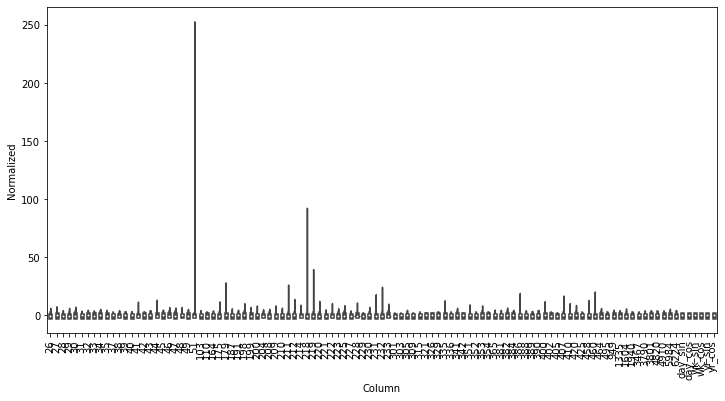

In [32]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [117]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
           train_df=train_df, val_df=val_df, test_df=test_df,
           label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col=None, max_subplots=3):
        if plot_col is None:
            if self.label_columns is not None:
                plot_col = self.label_columns[0]
            else:
                plot_col = list(self.column_indices)[0]
            
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')    

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result
    
    @example.setter
    def example(self, value):
        self._example = value
        

In [60]:
first_win = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['28'])
first_win

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['28']

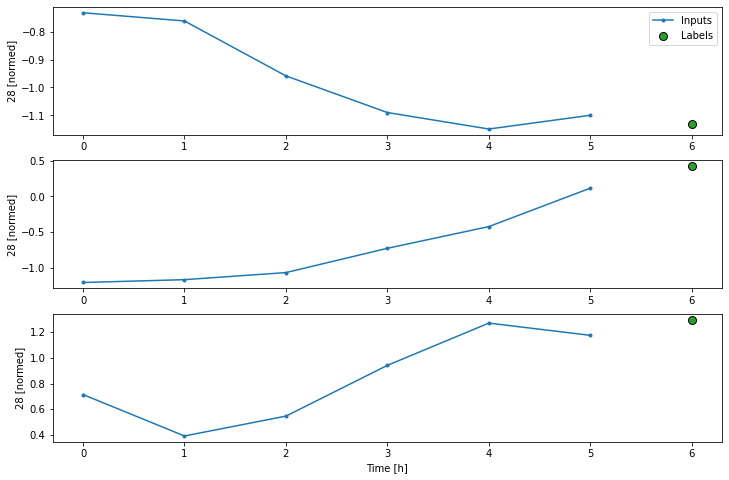

In [61]:
example_window = tf.stack([np.array(train_df[:first_win.total_window_size]),
                           np.array(train_df[100:100+first_win.total_window_size]),
                           np.array(train_df[200:200+first_win.total_window_size])])


example_inputs, example_labels = first_win.split_window(example_window)
first_win.example = example_inputs, example_labels
first_win.plot()

In [62]:
first_win.train.element_spec

(TensorSpec(shape=(None, 6, 107), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [63]:
for example_inputs, example_labels in first_win.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 107)
Labels shape (batch, time, features): (32, 1, 1)


In [64]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['28'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['28']

In [65]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 107)
Labels shape (batch, time, features): (32, 1, 1)


In [66]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [67]:
baseline = Baseline(label_index=column_indices['28'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

1050/1050 [==============================] - 3s 2ms/step - loss: 0.1300 - mean_absolute_error: 0.2563


In [68]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['28'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['28']

In [69]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 107)
Output shape: (32, 24, 1)


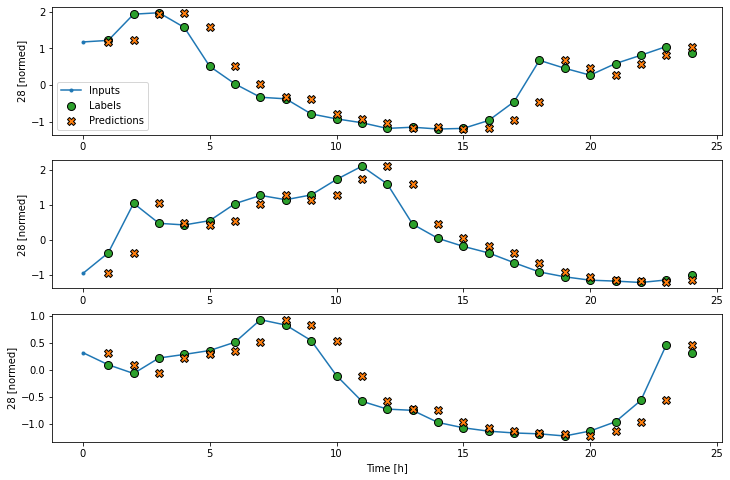

In [70]:
wide_window.plot(baseline)

In [71]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [72]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 107)
Output shape: (32, 1, 1)


In [73]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [74]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
3673/3673 [==============================] - 14s 4ms/step - loss: 0.2069 - mean_absolute_error: 0.2944 - val_loss: 0.0641 - val_mean_absolute_error: 0.1739
Epoch 2/20
3673/3673 [==============================] - 14s 4ms/step - loss: 0.0360 - mean_absolute_error: 0.1375 - val_loss: 0.0591 - val_mean_absolute_error: 0.1749
Epoch 3/20
3673/3673 [==============================] - 14s 4ms/step - loss: 0.0333 - mean_absolute_error: 0.1326 - val_loss: 0.0495 - val_mean_absolute_error: 0.1533
Epoch 4/20
3673/3673 [==============================] - 14s 4ms/step - loss: 0.0328 - mean_absolute_error: 0.1313 - val_loss: 0.0499 - val_mean_absolute_error: 0.1561
Epoch 5/20
3673/3673 [==============================] - 14s 4ms/step - loss: 0.0328 - mean_absolute_error: 0.1314 - val_loss: 0.0462 - val_mean_absolute_error: 0.1503
Epoch 6/20
3673/3673 [==============================] - 14s 4ms/step - loss: 0.0328 - mean_absolute_error: 0.1316 - val_loss: 0.0463 - val_mean_absolute_error: 0.148

In [75]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 107)
Output shape: (32, 24, 1)


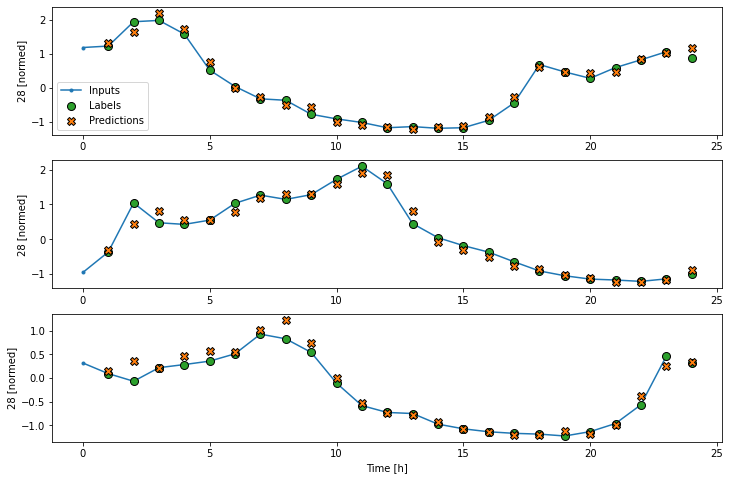

In [76]:
wide_window.plot(linear)

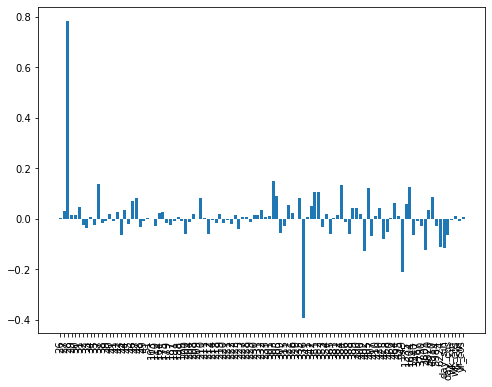

In [77]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [78]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
3673/3673 [==============================] - 20s 5ms/step - loss: 0.0743 - mean_absolute_error: 0.1576 - val_loss: 0.0420 - val_mean_absolute_error: 0.1377
Epoch 2/20
3673/3673 [==============================] - 19s 5ms/step - loss: 0.0182 - mean_absolute_error: 0.0957 - val_loss: 0.0373 - val_mean_absolute_error: 0.1389
Epoch 3/20
3673/3673 [==============================] - 20s 5ms/step - loss: 0.0158 - mean_absolute_error: 0.0893 - val_loss: 0.0396 - val_mean_absolute_error: 0.1447
Epoch 4/20
3673/3673 [==============================] - 19s 5ms/step - loss: 0.0145 - mean_absolute_error: 0.0856 - val_loss: 0.0328 - val_mean_absolute_error: 0.1197
Epoch 5/20
3673/3673 [==============================] - 19s 5ms/step - loss: 0.0137 - mean_absolute_error: 0.0831 - val_loss: 0.0329 - val_mean_absolute_error: 0.1190
Epoch 6/20
3673/3673 [==============================] - 20s 5ms/step - loss: 0.0133 - mean_absolute_error: 0.0821 - val_loss: 0.0313 - val_mean_absolute_error: 0.116

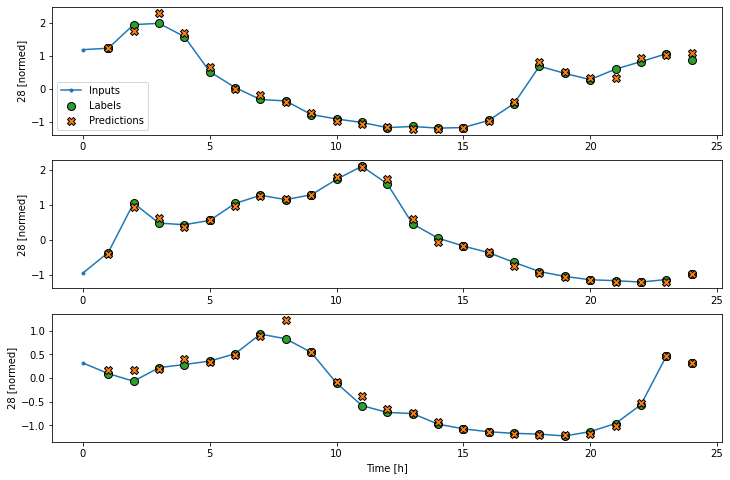

In [79]:
wide_window.plot(dense)

In [82]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['28'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['28']

In [83]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [84]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

1050/1050 [==============================] - 4s 3ms/step - loss: 0.0322 - mean_absolute_error: 0.1245


In [87]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['28'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['28']

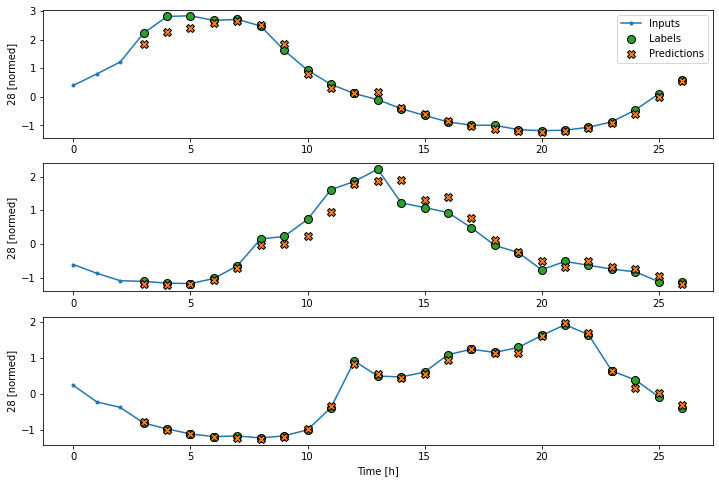

In [88]:
wide_conv_window.plot(conv_model)

In [89]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    # Must include batch_input_shape according to https://github.com/tensorflow/tensorflow/issues/37942
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [90]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

1049/1049 [==============================] - 4s 4ms/step - loss: 0.0259 - mean_absolute_error: 0.1032


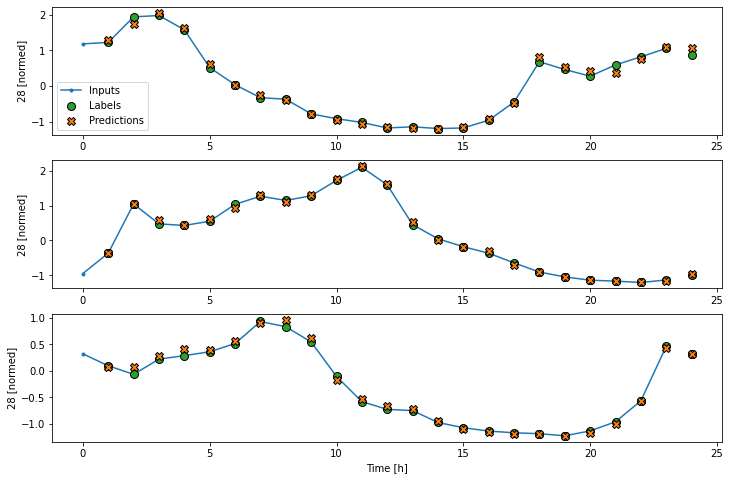

In [91]:
wide_window.plot(lstm_model)

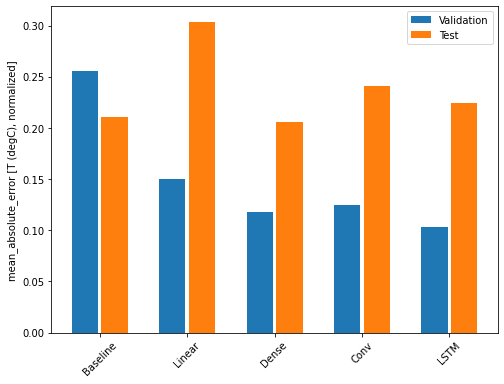

In [92]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [93]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 107)
Labels shape (batch, time, features): (32, 24, 107)


In [94]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [95]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

1049/1049 [==============================] - 3s 3ms/step - loss: 0.1982 - mean_absolute_error: 0.3001


In [96]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [97]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

1050/1050 [==============================] - 4s 4ms/step - loss: 0.1230 - mean_absolute_error: 0.2115


In [98]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

1049/1049 [==============================] - 4s 4ms/step - loss: 0.1273 - mean_absolute_error: 0.2108

Wall time: 1min 48s


In [99]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each timestep is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [100]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

1049/1049 [==============================] - 4s 4ms/step - loss: 0.0775 - mean_absolute_error: 0.1563

Wall time: 3min 27s


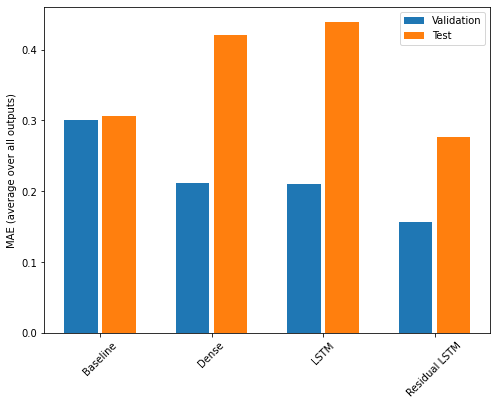

In [102]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [103]:
for name, value in performance.items():
    print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.3058
Dense          : 0.4202
LSTM           : 0.4385
Residual LSTM  : 0.2762


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

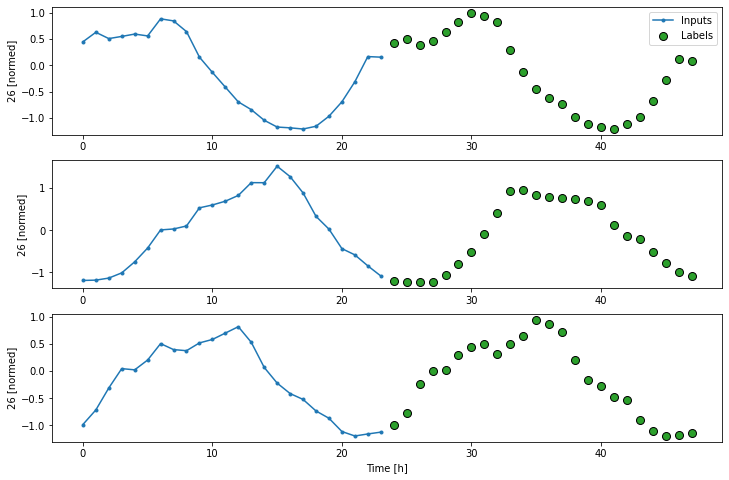

In [118]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

1048/1048 [==============================] - 3s 3ms/step - loss: 2.1317 - mean_absolute_error: 1.1218


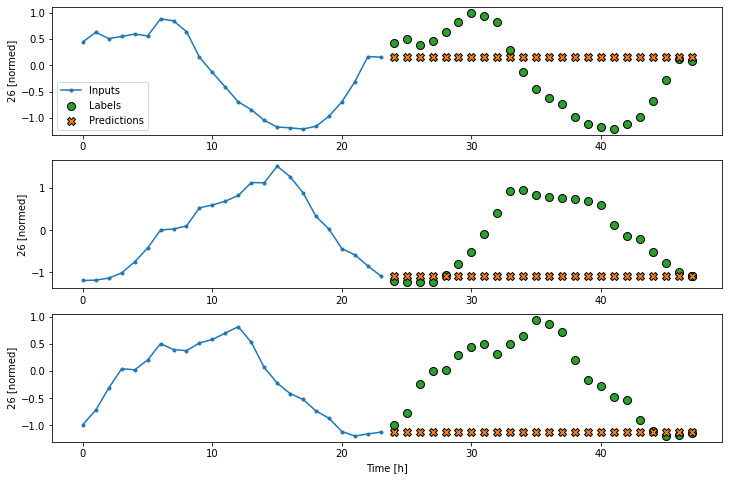

In [119]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

1048/1048 [==============================] - 3s 3ms/step - loss: 0.3222 - mean_absolute_error: 0.3251


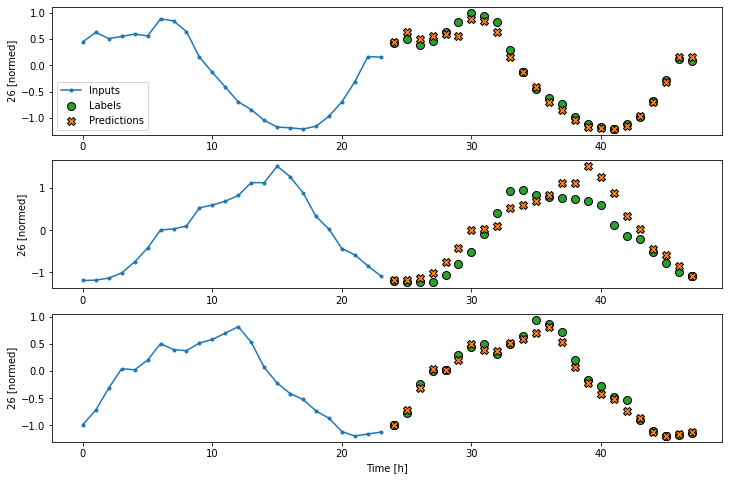

In [120]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

1048/1048 [==============================] - 3s 3ms/step - loss: 0.3334 - mean_absolute_error: 0.3838
Wall time: 52.1 s


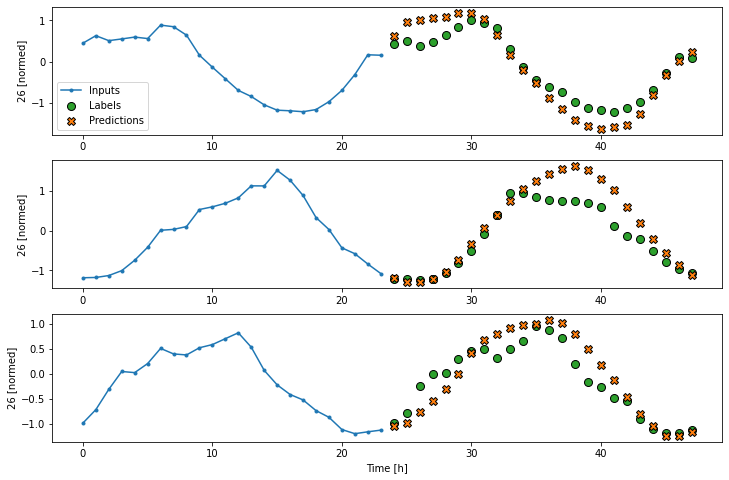

In [121]:
%%time
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

1048/1048 [==============================] - 4s 3ms/step - loss: 0.1924 - mean_absolute_error: 0.2730
Wall time: 3min 17s


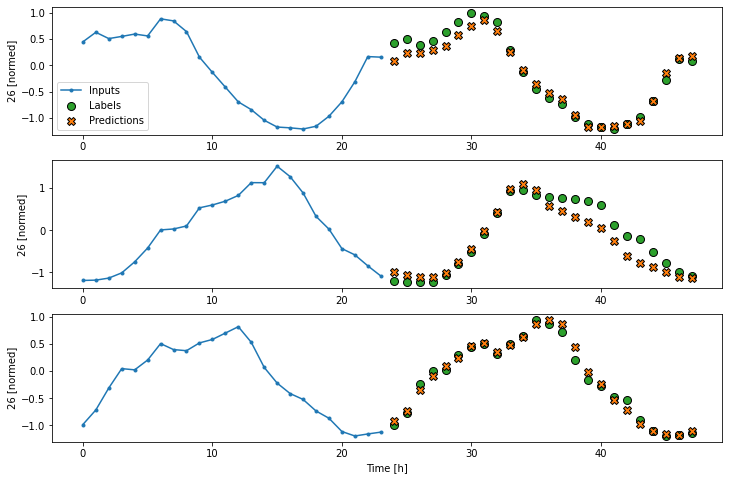

In [122]:
%%time
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

1048/1048 [==============================] - 4s 4ms/step - loss: 0.2008 - mean_absolute_error: 0.2810
Wall time: 3min 12s


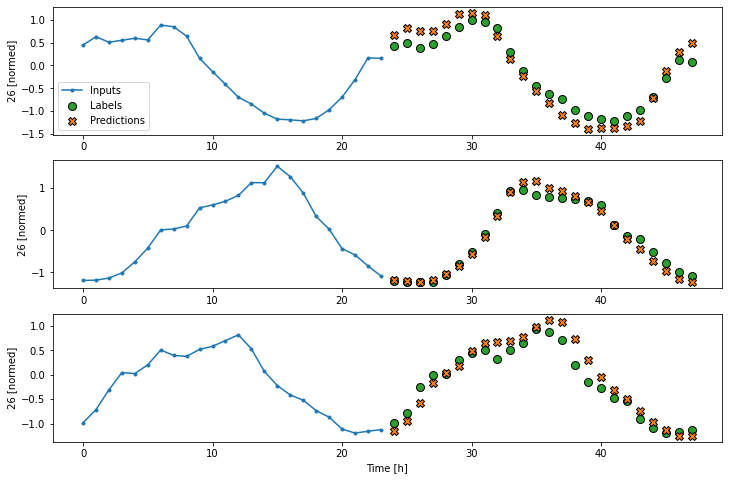

In [123]:
%%time
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

1048/1048 [==============================] - 7s 7ms/step - loss: 0.2266 - mean_absolute_error: 0.2994
Wall time: 16min 49s


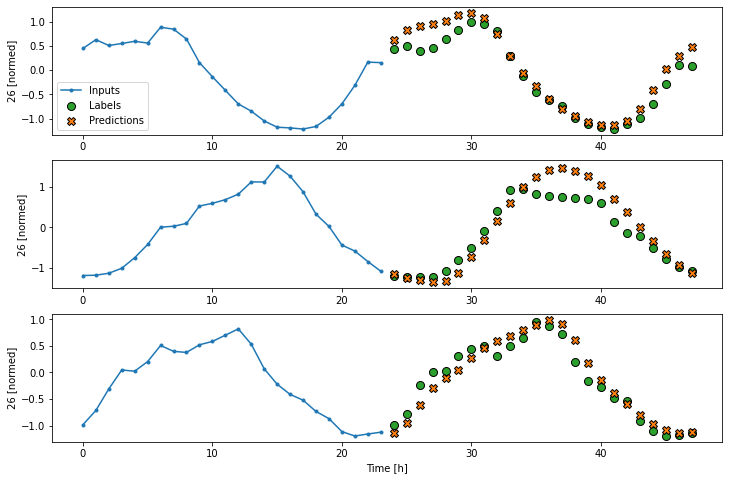

In [140]:
%%time
multi_rnn_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.SimpleRNN(32),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_rnn_model, multi_window)

IPython.display.clear_output()

multi_val_performance['RNN'] = multi_rnn_model.evaluate(multi_window.val)
multi_performance['RNN'] = multi_rnn_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_rnn_model)

1048/1048 [==============================] - 4s 4ms/step - loss: 0.2226 - mean_absolute_error: 0.2956
Wall time: 2min 1s


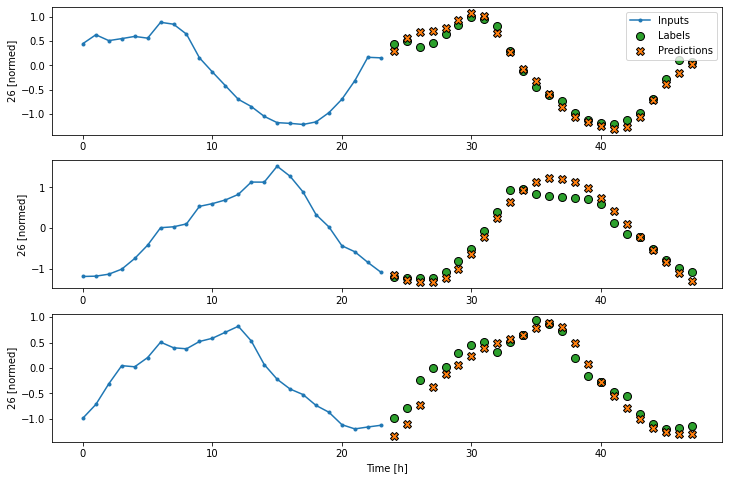

In [124]:
%%time
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [132]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
        
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state        

    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

In [133]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

1048/1048 [==============================] - 25s 24ms/step - loss: 0.1945 - mean_absolute_error: 0.2559
Wall time: 47min 28s


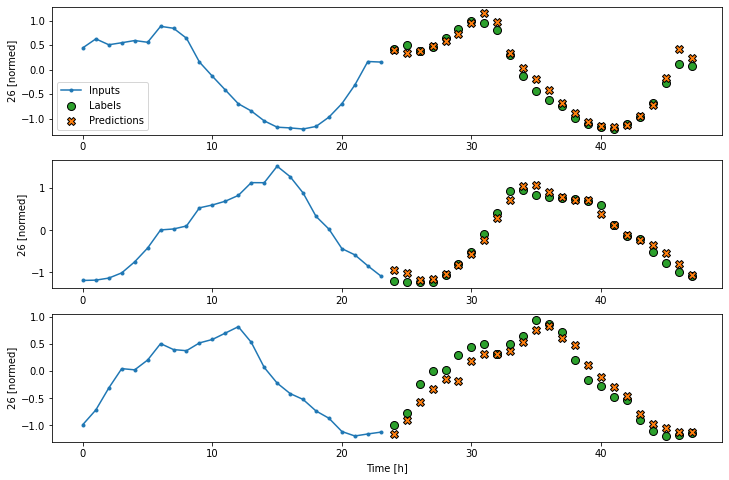

In [138]:
%%time
MAX_EPOCHS = 20
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

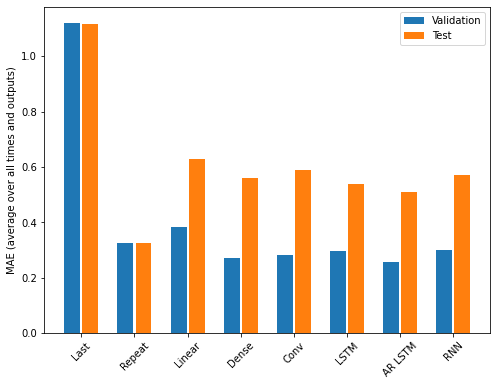

In [141]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [137]:
for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

Last    : 1.1149
Repeat  : 0.3261
Linear  : 0.6274
Dense   : 0.5599
Conv    : 0.5900
LSTM    : 0.5389
AR LSTM : 0.5260
